## Getting the class boundary through Black Box

This Ipython Notebook deals with fitting a black box model on a binary classifiable dataset (both linear and non linear as well as 2 dimensional and multi dimensional). A Minimal Distance Pair Algorithm is defined which works as follows:
1. Generate a random dataset under some confined boundaries.
2. Generate labels for the random dataset using the black box
3. Compute distance between the data points of each of the two classes
4. Choose N points such that the points which are of different classes and closer to each other have high probability of being chosen
5. Generate a dataset out of those close points.
6. Fit a new model on the new dataset and find its accuracy on the original dataset.

The basic idea behind this algorithm is that the points which belong to different classes and are close to one another will provide a sense of the hyperplane which is dividing the further two classes. With this sense of hyperplane we can create our new model such that it enables the new model to learn approximately the plane of separation of the black box. In this way the new model can intuitively work better on the original dataset

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [3]:
def generate_random(orig_data, feature_names, data_size):
    '''
    Input: Data, Feature Names, Size of Random Data
    Output: Random Data
    
    Generates random dataset of size data_size
    Random dataset is generated from normal
    distribution with specified high and low values
    '''
    
    df = {}
    for i in range(len(feature_names)):
        low = np.min(orig_data[:, i])
        high = np.max(orig_data[:, i])
        df[feature_names[i]] = np.random.uniform(low=low, high=high, size=data_size)
    random_dataset = pd.DataFrame(data=df, columns=feature_names)
    
    return random_dataset

In [4]:
def euclidean_dist(x1, x2):
    
    '''
    Input: x1 and x2 are numpy arrays or scalars
    Output: Euclidean distance between two high 
    dimensional arrays
    '''
    
    dist = np.sqrt(np.sum(np.square(x1 - x2)))
    return dist

In [5]:
def get_distance(X, y, label1, label2):
    
    '''
    Input: Numpy array representing data points
    Two labels between whose data points the distance
    needs to be found
    
    Output: Euclidean distance between each pair of data
    points
    '''
    
    distance = []
    points = []
    for x1 in X[y == label1, :]:
        for x2 in X[y == label2, :]:
            distance.append(euclidean_dist(x1, x2))
            points.append((x1, x2))
    return points, distance

In [6]:
def plotData(X, xaxis, yaxis, ax, labels=None, feature_names=None, title='Graph'):
    
    '''
    Input: Numpy array of data points
    Feature number for x axis
    Feature number for y axis
    labels representing the classes
    feature_names for features along both axes
    
    Output: Plot of the features 
    '''
    
    try:
        ax.scatter(X[:, xaxis], X[:, yaxis], c = labels, cmap=plt.cm.Spectral)
    except:
        ax.scatter(X[:, xaxis], X[:, yaxis])
        
    if feature_names:
        ax.set_xlabel(data.feature_names[xaxis])
        ax.set_ylabel(data.feature_names[yaxis])
    ax.set_title(title)

In [7]:
def labelInfo(labels):
    
    '''
    Produces label information
    '''
    
    dist = Counter(labels).most_common()
    for tup in dist:
        print 'Label: ', tup[0], 'Count: ', tup[1]

In [8]:
def applyAlgo(X_random, y_random, label1, label2, num_points=1000, num_choose=100):
    
    '''
    Apply the algorithm of minimum euclidean distances
    '''
    
    points, distance = get_distance(X_random, y_random, label1, label2)
    assert len(points) == len(distance)
    args = np.argsort(distance)[0:num_points]
    points = np.asarray(points)
    random_points = points[np.random.choice(args, num_choose)]
    random_points = random_points.reshape((num_choose*2, X_random.shape[1]))
    label = [label1 if x%2 == 0 else label2 for x in np.arange(random_points.shape[0])]
    
    return random_points, label

## Linearly Separable Data

In [ ]:
## Data Wrangling
data = datasets.load_iris()
X = data.data[:, :2]
y = data.target
X = X[(y == 0) | (y == 1), :]
y = y[(y == 0) | (y == 1)]

## Plotting the data
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
plotData(X, 0, 1, ax, y, feature_names=data.feature_names, title='Original Dataset')

## Fitting black box to original data
blackbox = LogisticRegression()
blackbox.fit(X, y)
print 'Blackbox score on the random dataset: ', blackbox.score(X, y)

## Generating random samples
X_random = generate_random(X, data.feature_names[0:2], data_size=1000).values
y_random = blackbox.predict(X_random)
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print 'Whitebox score when trained with random dataset: ', whitebox.score(X, y)

## Getting label information
labelInfo(y_random)
ax = fig.add_subplot(122)
plotData(X_random, 0, 1, ax, labels=y_random, feature_names=data.feature_names, title='Random Dataset')

## Applying the algorithm
new_data, new_labels = applyAlgo(X_random, 0, 1)

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plotData(new_data, 0, 1, ax, new_labels, feature_names=data.feature_names, title="Minimal Distance Dataset")

In [ ]:
whitebox = LogisticRegression()
whitebox.fit(new_data,new_labels)
print 'Score of whitebox on original dataset: ', whitebox.score(X, y)

** Score is equivalent with the black box. The model works fine on simple dimensions ** :)

## Non Linearly Separable Data

In [ ]:
import tensorflow as tf

In [ ]:
tf.reset_default_graph()

In [ ]:
with tf.variable_scope("Input") as scope:
    input_data = tf.placeholder(dtype=tf.float32, shape=[None, 2], name="Input_data")
    labels = tf.placeholder(dtype=tf.float32, shape=[None,2], name="labels")

In [ ]:
with tf.variable_scope("hidden_layer") as scope:
    w = tf.get_variable(dtype=tf.float32, shape=[2, 128], initializer=tf.random_normal_initializer(), name="weights")
    b = tf.get_variable(dtype=tf.float32, shape=[128], initializer=tf.random_normal_initializer(), name="biases")
    out = tf.nn.relu(tf.matmul(input_data, w) + b)

In [ ]:
with tf.variable_scope("output_layer") as scope:
    w = tf.get_variable(dtype=tf.float32, shape=[128, 2], initializer=tf.random_normal_initializer(), name="weights")
    b = tf.get_variable(dtype=tf.float32, shape=[2], initializer=tf.random_normal_initializer(), name="biases")
    softmax = tf.nn.softmax(tf.matmul(out,w) + b)

In [ ]:
with tf.variable_scope("loss") as scope:
    loss = tf.reduce_mean(-tf.reduce_sum(labels*tf.log(softmax), reduction_indices=[1]))

In [ ]:
with tf.variable_scope("optimizer") as scope:
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [ ]:
## Data Wrangling
data = datasets.make_moons()
X, y = data
color = y
y = pd.get_dummies(y)
feature_names = ['feature1', 'feature2']

## Plotting the data
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
plotData(X, 0, 1, ax, color,title='Original Dataset')

## Generating random samples
X_random = generate_random(X, feature_names, data_size=1000).values

## Fitting the black box and generating labels for random dataset
l, i = 1000, 1
epsilon = 1e-2
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    while l > epsilon:
        
        _, l = sess.run([optimizer, loss], feed_dict={input_data:X, labels:y})
        
        if i % 1000 == 0:
            
            print 'Epoch: {}\n Loss: {}'.format(i, l)
        i += 1
    
    ## Generating labels for random data
    y_random = sess.run([softmax], feed_dict={input_data:X_random})

## Getting label information
y_random = np.argmax(y_random[0], 1)
labelInfo(y_random)

## Performance of white box when trained with random data
whitebox = RandomForestClassifier()
whitebox.fit(X_random, y_random)
print 'Whitebox score when trained on the random dataset: ', whitebox.score(X, data[1])

ax = fig.add_subplot(122)
plotData(X_random, 0, 1, ax, labels=y_random, title='Random Dataset')

## Applying the algorithm
new_data, new_labels = applyAlgo(X_random, 0, 1)

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plotData(new_data, 0, 1, ax, new_labels, title="Minimal Distance Dataset")

In [ ]:
whitebox = RandomForestClassifier()
whitebox.fit(new_data, pd.get_dummies(new_labels))
print 'Score of Whitebox on original data', whitebox.score(X, y)

** Works well on non linear data, although the data is still in 2 dimensions **

## High Dimensional Data

In [ ]:
## Data Wrangling
data = datasets.load_iris()
X = data.data
y = data.target
X = X[(y == 0) | (y == 1), :]
y = y[(y == 0) | (y == 1)]

## Plotting the data
title = 'Original Dataset'
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(131)
plotData(X, 0, 1, ax, y, data.feature_names, title=title)
ax = fig.add_subplot(132)
plotData(X, 1, 2, ax, y, data.feature_names, title=title)
ax = fig.add_subplot(133)
plotData(X, 2, 3, ax, y, data.feature_names, title=title)
plt.show()

## Fitting the black box model
blackbox = LogisticRegression()
blackbox.fit(X, y)

## Generating random samples
X_random = generate_random(X, data.feature_names, data_size=1000).values
y_random = blackbox.predict(X_random)

## Performance of whitebox with random dataset
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print 'Whitebox performance when trained with random dataset: ', whitebox.score(X, y)

## Getting label information
labelInfo(y_random)

## Plotting the random  data
title = 'Random Dataset'
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(131)
plotData(X_random, 0, 1, ax, labels=y_random, feature_names=data.feature_names, title=title)
ax = fig.add_subplot(132)
plotData(X_random, 1, 2, ax, labels=y_random, feature_names=data.feature_names, title=title)
ax = fig.add_subplot(133)
plotData(X_random, 2, 3, ax, labels=y_random, feature_names=data.feature_names, title=title)
plt.show()

## Applying the algorithm
new_data, new_labels = applyAlgo(X_random, 0, 1)

In [ ]:
title='Minimal Distance Dataset'
fig = plt.figure(figsize=(11, 4))
ax = fig.add_subplot(131)
plotData(new_data, 0, 1, ax, labels=new_labels, feature_names=data.feature_names, title=title)
ax = fig.add_subplot(132)
plotData(new_data, 1, 2, ax, labels=new_labels, feature_names=data.feature_names, title=title)
ax = fig.add_subplot(133)
plotData(new_data, 2, 3, ax, labels=new_labels, feature_names=data.feature_names, title=title)
plt.show()

The minimal distance points generated are not so obviously separated into the two classes but it can be hypothesized that a plane which perfectly separates the classes (** in high dimensions **) can be represented by this new dataset. 

In [ ]:
whitebox = LogisticRegression()
whitebox.fit(new_data, new_labels)
print 'Score of whiteboard on the original data: ', whitebox.score(X, y)

## Very High Dimensional Data
e.g. heart.csv

In [ ]:
from sklearn.svm import SVC

In [ ]:
## Data Wrangling
data = pd.read_csv('../data/heart.csv')
data['famhist'] = data['famhist'].map({'Absent': 0, 'Present': 1})
y = data.pop('chd').values
feature_names = data.columns
X = data.values

## Fitting the black box model
blackbox = LogisticRegression()
blackbox.fit(X, y)
print 'Black Box accuracy on the original dataset: ', blackbox.score(X, y)

## Generating random samples
X_random = generate_random(X, feature_names, data_size=1000).values
y_random = blackbox.predict(X_random)

## Whitebox performance with the random dataset
whitebox = LogisticRegression()
whitebox.fit(X_random, y_random)
print 'Whitebox performance when trained on random examples: ', whitebox.score(X, y)
## Getting label information
labelInfo(y_random)

## Applying the algorithm
new_data, new_labels = applyAlgo(X_random, 0, 1)

In [ ]:
whitebox = LogisticRegression()
whitebox.fit(new_data, new_labels)
print 'White Box accuracy on the original dataset', whitebox.score(X, y)

## On different models

In [9]:
import copy

In [10]:
def flowModels(models, X, y, feature_names, data_size=5000):
    accuracy_wb = []
    accuracy_bb = []
    accuracy_random = []
    
    for model in models:
        print '*'*30
        print model
        
        blackbox = copy.deepcopy(model)
        blackbox.fit(X, y)
        score = blackbox.score(X, y)
        print 'Black Box accuracy on the original dataset: ', score
        accuracy_bb.append(score)

        ## Generating random samples
        X_random = generate_random(X, feature_names, data_size=data_size).values
        y_random = blackbox.predict(X_random)
        
        whitebox = copy.deepcopy(model)
        whitebox.fit(X_random, y_random)
        score = whitebox.score(X,y)
        accuracy_random.append(score)

        ## Getting label information
        labelInfo(y_random)

        ## Applying the algorithm
        new_data, new_labels = applyAlgo(X_random, y_random, 0, 1, num_points=data_size, num_choose=500)
        
        whitebox = copy.deepcopy(model)
        whitebox.fit(new_data, new_labels)
        score = whitebox.score(X, y)
        print 'White Box accuracy on the original dataset', score
        print '*'*30
        accuracy_wb.append(score)
        
    return accuracy_bb, accuracy_wb, accuracy_random

In [11]:
## Data Wrangling
data = pd.read_csv('../data/heart.csv')
data['famhist'] = data['famhist'].map({'Absent': 0, 'Present': 1})
y = data.pop('chd').values
feature_names = data.columns
X = data.values

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier

In [13]:
models = [RandomForestClassifier(), LogisticRegression(), LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(),
         RidgeClassifier()]

In [14]:
ac_bb, ac_wb, ac_r = flowModels(models, X, y, feature_names)

******************************
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Black Box accuracy on the original dataset:  0.984848484848
Label:  0 Count:  2850
Label:  1 Count:  2150
White Box accuracy on the original dataset 0.677489177489
******************************
******************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Black Box accuracy on the original dataset:  0.733766233766
Label:  0 Count:  2631
Label:  1 Co

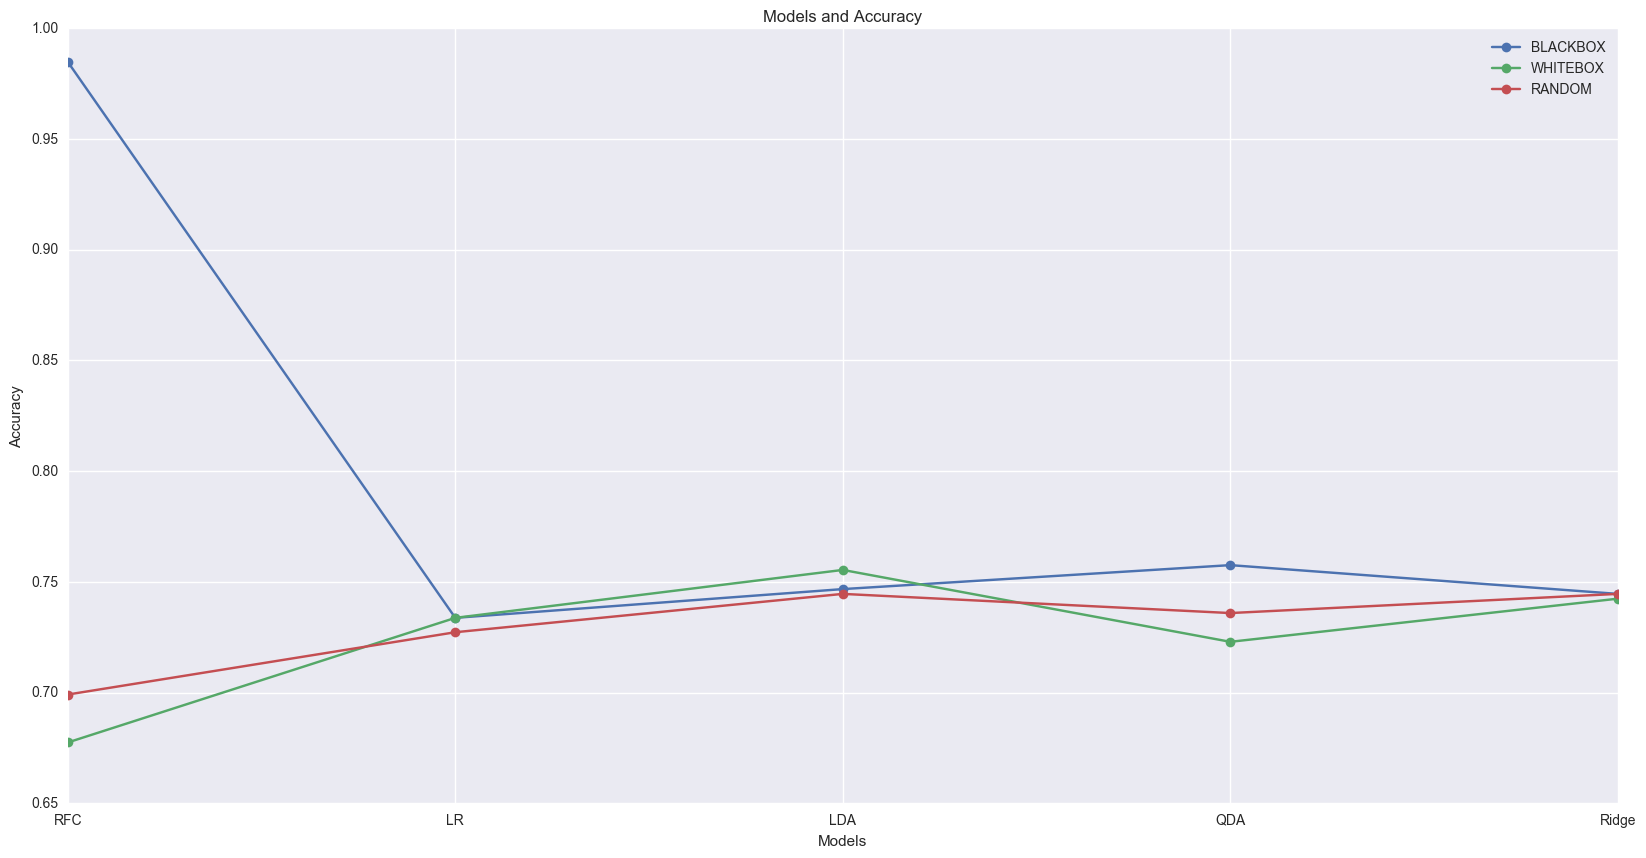

In [15]:
my_xticks = ['RFC', 'LR', 'LDA', 'QDA', 'Ridge']
x = np.arange(len(my_xticks))
plt.xticks(x, my_xticks)
plt.plot(x, ac_bb, '-o', label='BLACKBOX')
plt.plot(x, ac_wb, '-o', label='WHITEBOX')
plt.plot(x, ac_r, '-o', label='RANDOM')
plt.title('Models and Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.show()